<style>
    @media print{
        body {
            position:relative !important;
        }
        .celltag_new_page {
            page-break-before: always !important;
        }
    }
</style>
# COMPSCI 371D Homework 4

Olivia Fan, Sam Carpenter, Frankie Willard

### Problem 0 (3 points)

## Part 1: Stochastic Gradient Descent 

In [124]:
from urllib.request import urlretrieve
from os import path as osp


def retrieve(file_name, semester='fall21', course='371d', homework=4):
    if osp.exists(file_name):
        print('Using previously downloaded file {}'.format(file_name))
    else:
        fmt = 'https://www2.cs.duke.edu/courses/{}/compsci{}/homework/{}/{}'
        url = fmt.format(semester, course, homework, file_name)
        urlretrieve(url, file_name)
        print('Downloaded file {}'.format(file_name))


In [125]:
import pickle


data_file_name = 'samples.pkl'
code_file_names = ('decorators.py', 'function.py')
for name in (data_file_name, *code_file_names):
    retrieve(name)

from decorators import HistoryTracker
from function import f, phi

with open(data_file_name, 'rb') as file:
    data = pickle.load(file)

Using previously downloaded file samples.pkl
Using previously downloaded file decorators.py
Using previously downloaded file function.py


In [126]:
import autograd.numpy as np
from autograd import grad

z_0 = np.array((0.4, 0.1))
f_0 = f(z_0, data)
plot_info = {
        'z_0': z_0,
        'f_0': f_0,
        'z_ast': phi.z_ast,
        'x_range': [-1., 2.5],
        'y_range': [-2.2, 1.],
}

In [127]:
def plot_contours(fct, samples, info, title=None, hist=None,
                  grid_samples=101, marker_size=15, font_size=20):
    x = np.linspace(info['x_range'][0], info['x_range'][1], grid_samples)
    y = np.linspace(info['y_range'][0], info['y_range'][1], grid_samples)
    box = (x[0], x[-1], y[0], y[-1])
    x_grid, y_grid = np.meshgrid(x, y)
    z_grid = np.stack((x_grid, y_grid), axis=0)
    fct_grid = fct(z_grid, samples)
    fig = plt.figure(figsize=(13, 12), tight_layout=True)
    img = plt.imshow(fct_grid, interpolation='bilinear',
               origin='lower', extent=box, cmap=cm.hot)
    plt.contour(x_grid, y_grid, fct_grid, 50, colors='w', linewidths=1)
    plt.plot(info['z_0'][0], info['z_0'][1], 'bo', markersize=marker_size)
    plt.plot(info['z_ast'][0], info['z_ast'][1], 'go', markersize=marker_size)
    plt.axis('scaled')
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    label_size = (font_size * 1.5) // 1
    plt.xlabel('$z_0$', fontsize=label_size)
    plt.ylabel('$z_1$', fontsize=label_size)
    bar = fig.colorbar(img, shrink=0.72)
    bar.ax.tick_params(labelsize=font_size)
    if hist is not None:
        hz = hist['z']
        plt.plot(hz[:, 0], hz[:, 1], color='w', linewidth=2)
    if title is not None:
        plt.title(title, fontsize=font_size)
    plt.show()

In [128]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [129]:
from numpy import random as npr


def batch_index_generator(n_samples, batch_size):
    rg = npr.default_rng(15)
    batch = rg.permutation(n_samples)
    start, stop = 0, batch_size
    while stop < n_samples:
        yield batch[start:stop]
        start += batch_size
        stop += batch_size
    stop = min(stop, n_samples)
    yield batch[start:stop]


@HistoryTracker
def step(fct, samples, z, alpha):
    def fct_batch(u):
        return fct(u, samples)
    z_prime = z - alpha * grad(fct_batch)(z)
    f_prime = fct_batch(z_prime)
    return z_prime, f_prime

### Problem 1.1 (Exam-Style)

The number of evaluations of phi in a single epoch depends on the size of the mini-batch, because the smaller the mini-batch, the smaller subset of loss functions gets evaluated.

### Problem 1.2

In [145]:
from math import dist

def sgd(fct, samples, z, batch_size, alpha, min_step=1.e-5, max_epochs=5000):
    num_epochs = 0;
    
    while num_epochs < max_epochs:
        for batch_indices in batch_index_generator(1000, batch_size):
            #main step in gradient descent
            #returns next value of z and corresponding f(z)
            current_step = step(fct, samples[batch_indices], z, alpha)
            #new z after calculating the step
            z_new = current_step[0]
            #progress
            progress = dist(z,z_new)
            z = z_new
            if progress < min_step:
                return z, num_epochs
                break
        num_epochs = num_epochs+1
    print ("Max_epochs exceeded.")
    return z, num_epochs

In [146]:
def experiment(batch_size, alpha, info):
    phi.reset()

    step.restart(plot_info["z_0"], plot_info["f_0"])

    z, n = sgd(f, data, plot_info["z_0"][:], batch_size, alpha)

    title = (
        "Contour plot with learning rate "
        + str(alpha)
        + ", batch size "
        + str(batch_size)
        + ", "
        + str(phi.calls())
        + " evaluations, and "
        + str(n)
        + " total epochs."
    )

    plot_contours(f, data, info, hist=step.history(), title=title)

Max_epochs exceeded.
[ 0.70355373 -0.92118215]
5000


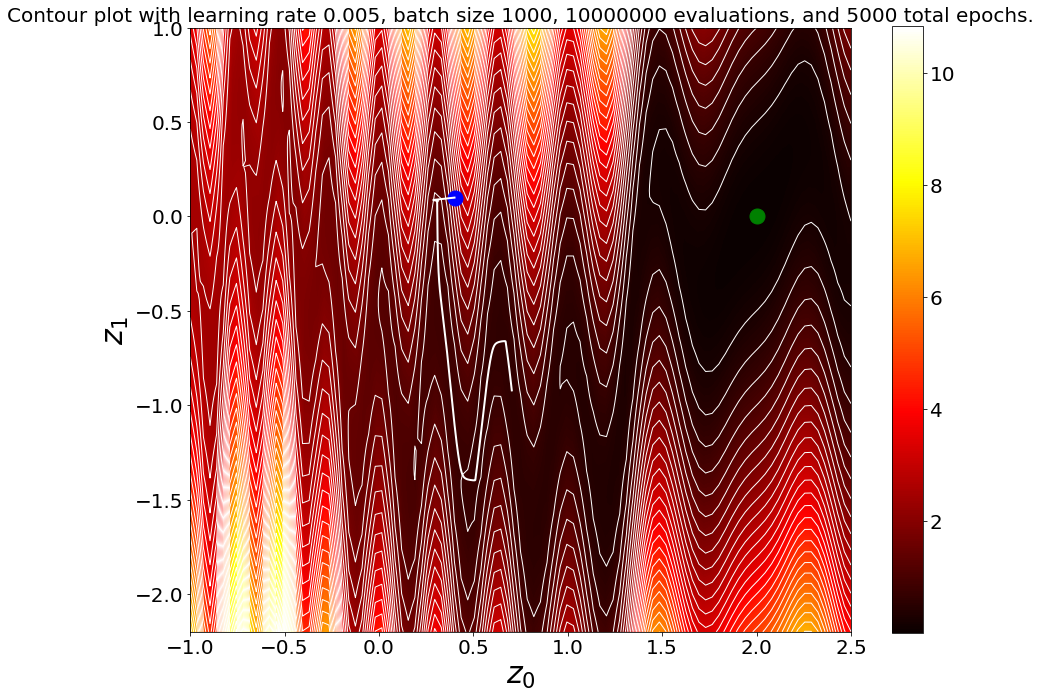

In [147]:
bsize = len(data)
experiment(bsize, 0.005, plot_info)

Max_epochs exceeded.
[ 0.93953586 -1.00883864]
5000


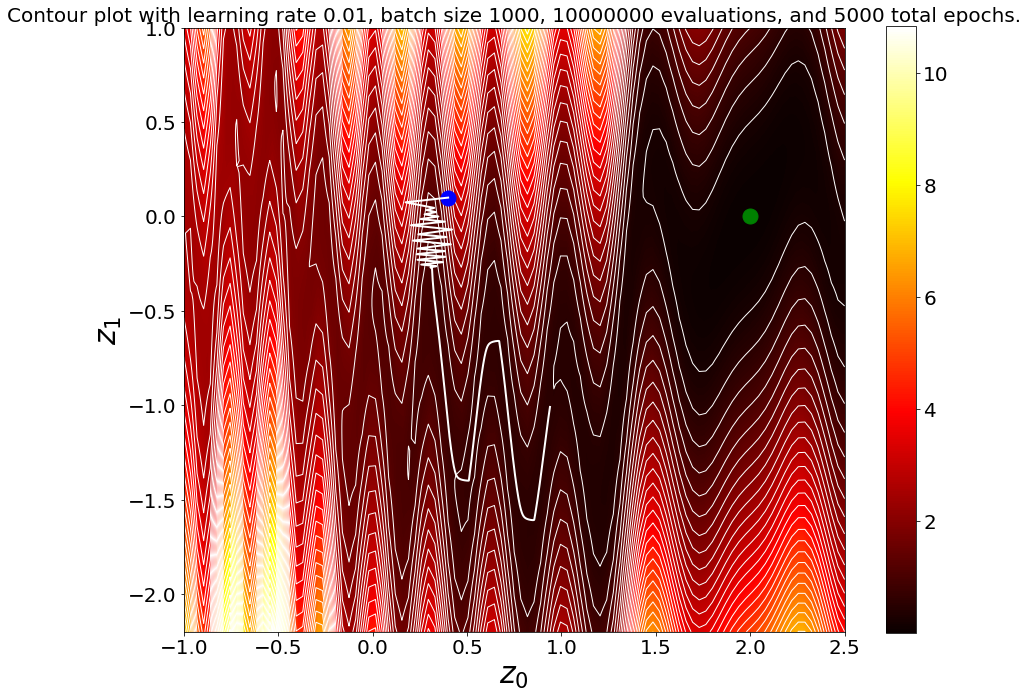

In [148]:
experiment(bsize, 0.01, plot_info)

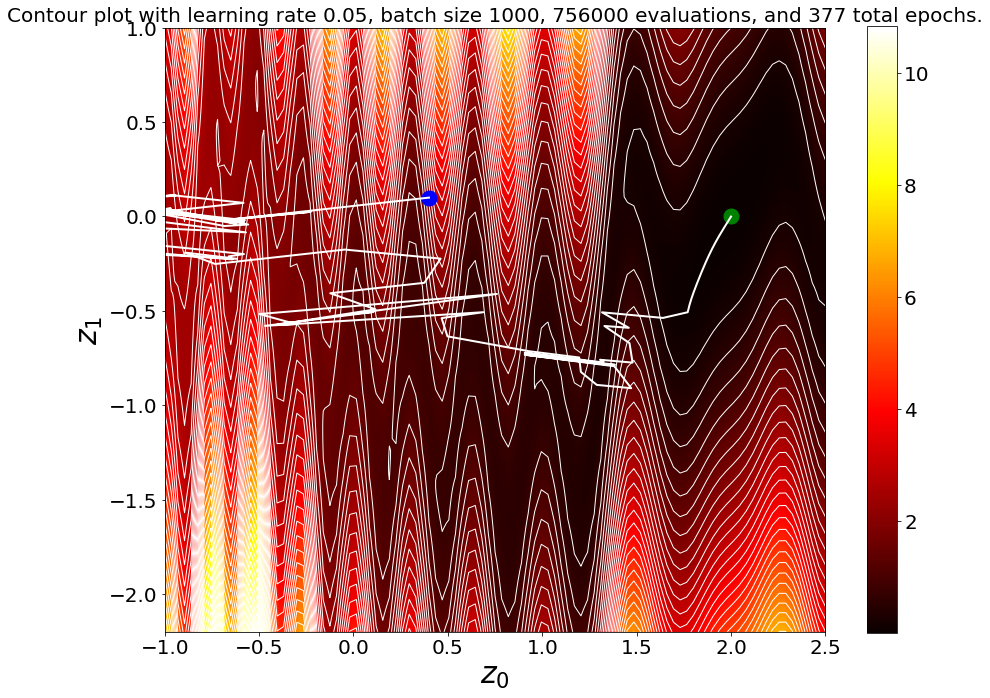

In [149]:
experiment(bsize, 0.05, plot_info)

### Problem 1.3 (Exam Style)

Only the largest learning rate converged - that said, it did so extremely chaotically. The two smaler rates, 0.005 and 0.01, both moved along the path to the global minimum, but did so slowly and were completely unable to converge. Given a very large amount of epochs, they might be able to eventually converge, but would continue to do so very slowly.

<br>The largest leraning rate, 0.05, did converge but did so very chaotically. The jumps it takes are large, and often point away from the global minimum. Although this worked in two dimensions, it would likely not generalize to more dimensions, since it would be less likely to get lucky and point towards the right answer.

### Problem 1.4

Max_epochs exceeded.
[ 0.70400215 -0.9224894 ]
5000


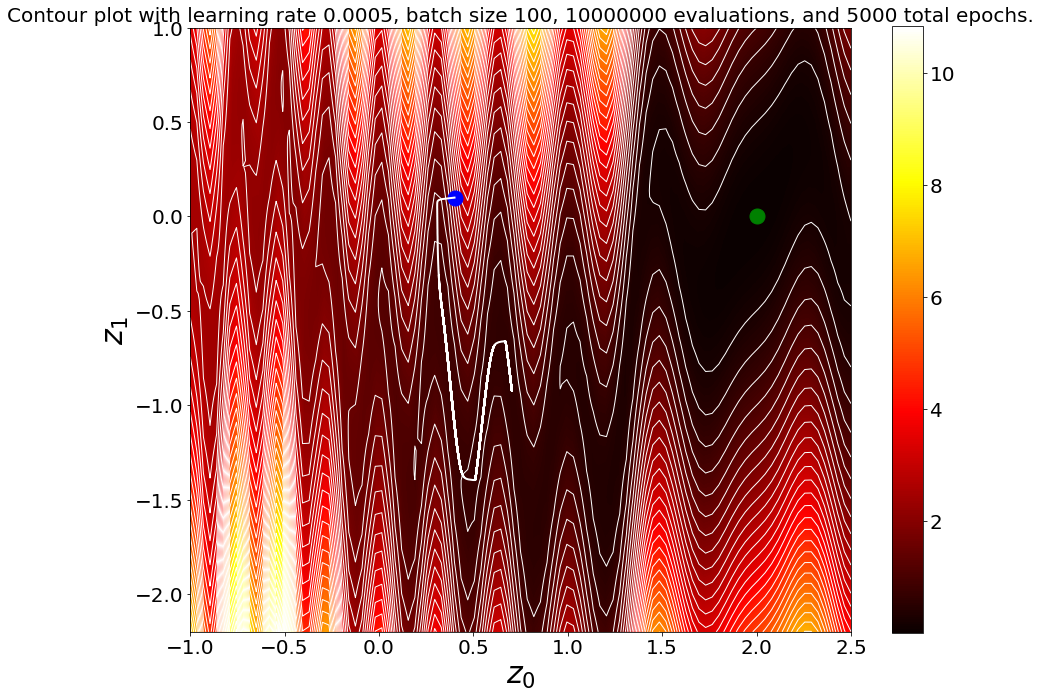

In [153]:
bsize = 100
experiment(bsize, 0.0005, plot_info)

Max_epochs exceeded.
[ 0.93832941 -1.01555386]
5000


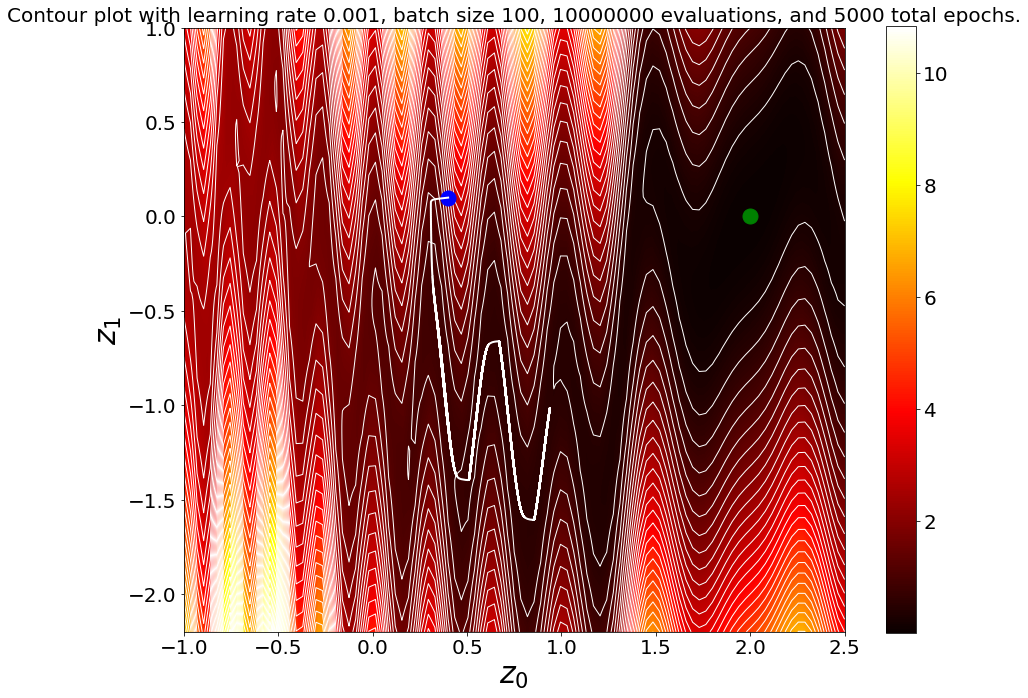

In [151]:
experiment(bsize, 0.001, plot_info)

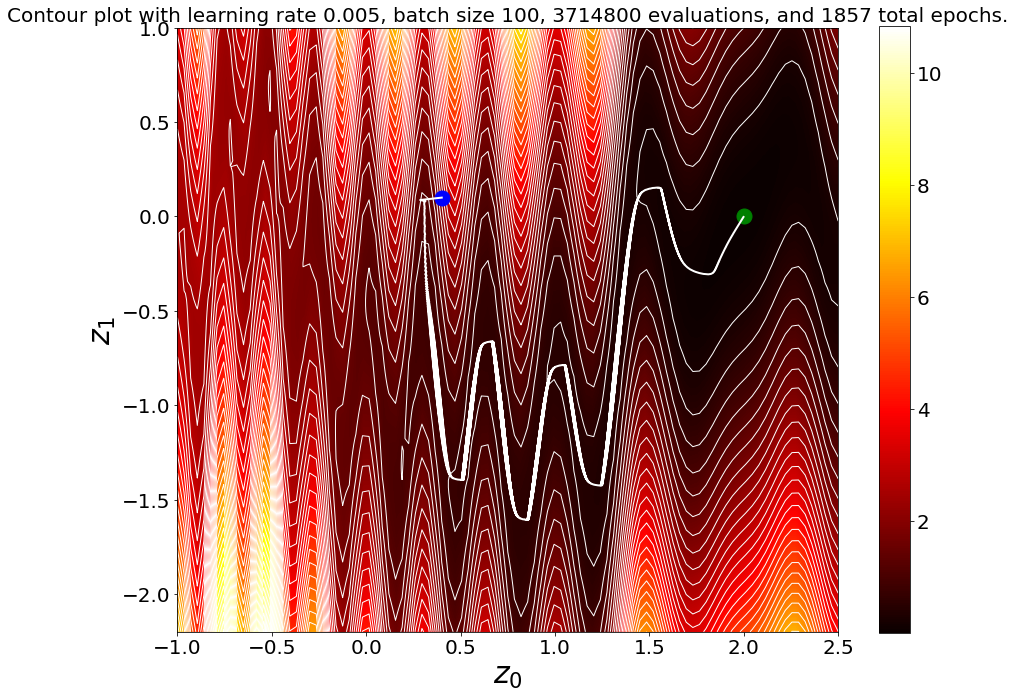

In [152]:
experiment(bsize, 0.005, plot_info)

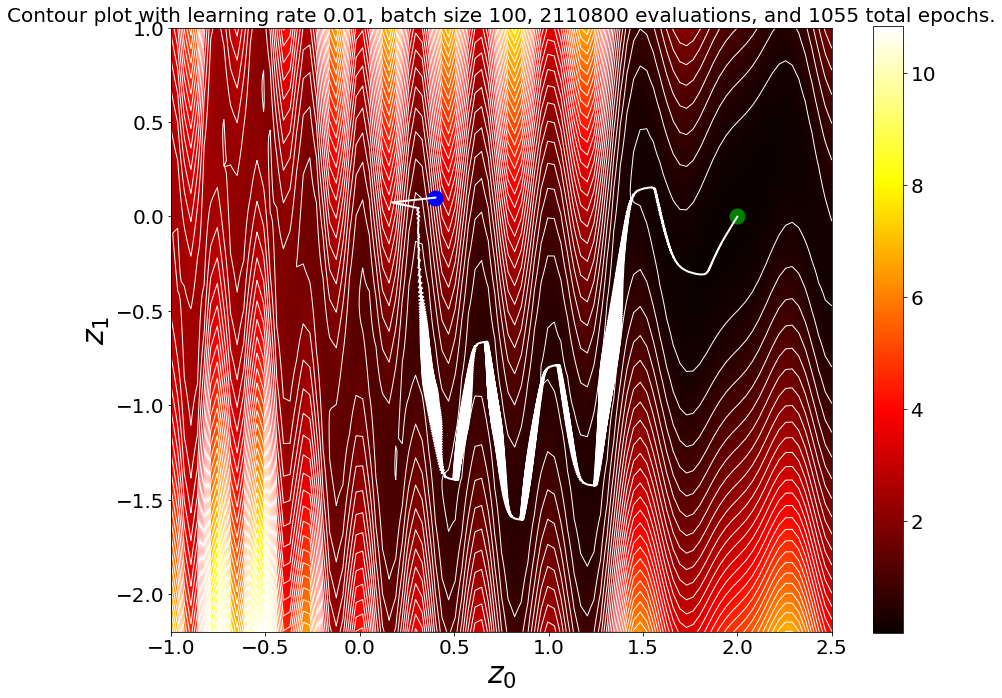

In [154]:
experiment(bsize, 0.01, plot_info)

### Problem 1.5 (Exam Style)

The two larger learning rates, 0.005 and 0.01, were able to converge to the global minimum, ending before the maximum number of epochs completed. The smaller two followed the same path, but were unable to converge as they moved too slowly towards the global minimum; given a much larger epoch count, they may have converged, but could not with 5000 epochs.

<br>In general, both of the higher learning rates were fully capable of converging. For this particular example, the higher learning rate was preferable thanks to the increased speed. That being said, for SGD in general, the lower learning rate of 0.005 will likely have more success generalizing to higher dimension datasets thanks to the less chaotic steps it takes, increasing the likelihood of convergence.

<br> In all cases, the path is ocassionally varied from, though on average it moves in the correct direction. This gives more credence to the idea that 0.005 will likely be a good learning rate as opposed to 0.01, since it varies much less.

<br> It would be harder to select a good fixed learning rate when z lives in spaces with many dimensions, because there would be much more evaluations being performed in order the process of finding an optimal learning rate that is fast enough to reach convergence but also results in less chaotic steps which means higher likelihood of convergence. The function evaluation and gradient calculation would be more expensive, and it would be difficult to visually tell what the path is doing, so experiments would be harder.

### Problem 1.6 (Exam Style)

For a fixed learning rate, SGD was able to converge substantially faster than standard gradient descent. The steps it takes are smaller, and there are more of them, for the same amount of evaluations. The direction of the steps varies, but on average they move in the correct direction; the steps therefore quickly move in the right direction. Though there are smaller steps, and more, the steps were accurate on average and much easier to compute.

<br> As evidence, for a fixed learning rate 0.01, gradient descent was unable to converge after ten million evaluations. However, SGD was able to converge with the same learning rate after about just over two million evaluations (2110800).

## Part 2: Hyperplanes

### Problem 2.1 (Exam Style)

We can first write the equation of the plane $ 2x+2y+z = 3$ in the form of $ax+by+cz+d = 0$ to get $$ 2x+2y+z - 3=0 $$
According to the coefficents, the normal vector to the plane is $$ n = \space <a,b,c> \space = \space <2,2,1> $$
Therefore, the Euclidean distance d between the point and the plane can be calculated according to the distance formula:
$$ D = \frac{|ax_1+by_1+cz_1+d|}{\sqrt{a^2+b^2+c^2}} \\
= \frac{|2(1)+2(0)+1(4)-3|}{\sqrt{2^2+2^2+1^2}}\\
= \frac{3}{\sqrt{9}}\\
= \frac{3}{3} \\
= 1 $$

### Problem 2.2 (Exam Style)

$$
o=(x_0,y_0,z_0)\\
o = (0,0,0)^T\\
p=(x_1,y_1,z_1)\\
p = (1,0,4)^T\\
$$
The distance from point p to the origin can be calculated from the distance formula 
$$D = \sqrt{(x_1-x_0)^2 + (y_1-y_0)^2+(z_1-z_0)^2}\\
= \sqrt{(1-0)^2 + (0-0)^2+(4-0)^2} \\
= \sqrt{17} > 1 $$
Therefore, the point p is closer to the origin than the plane Π.

### Problem 2.3 (Exam Style)

If Π' is parallel to Π, then they must have parallel normal vectors.
We can thus use the normal vector n with the vector definition of a plane equation to find the plane equation through our given point and parallel to the given plane
$$
n=(2,2,1)^T\\
x_0 = (1,0,4)^T\\
n \cdot x = n \cdot x_0\\
n \cdot (x - x_0) = 0\\
\left[\begin{array}{cc} 2 \\ 2 \\ 1 \end{array}\right] \cdot (\left[\begin{array}{cc} x \\ y \\ z \end{array}\right] - \left[\begin{array}{cc} 1 \\ 0 \\ 4 \end{array}\right])=0\\
\left[\begin{array}{cc} 2 \\ 2 \\ 1 \end{array}\right] \cdot (\left[\begin{array}{cc} x-1 \\ y-0 \\ z-4 \end{array}\right] =0\\
2(x-1)+2(y-0)+(z-4)=0\\
2x-2+2y+z-4=0\\
2x+2y+z-6=0\\
w_x = 2, w_y = 2, w_z = 1, c = -6
$$